In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler



df = pd.read_csv('day.csv')

## Borrar variables

In [2]:
df = df.drop(columns=['casual','registered','instant','dteday','mnth','yr'])
target = 'cnt'
df.head()

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


## Dummies

In [3]:
df = pd.get_dummies(df, columns=['season','weathersit','weekday'])
df.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,...,weathersit_1,weathersit_2,weathersit_3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.344167,0.363625,0.805833,0.160446,985,True,False,False,...,False,True,False,False,False,False,False,False,False,True
1,0,0,0.363478,0.353739,0.696087,0.248539,801,True,False,False,...,False,True,False,True,False,False,False,False,False,False
2,0,1,0.196364,0.189405,0.437273,0.248309,1349,True,False,False,...,True,False,False,False,True,False,False,False,False,False
3,0,1,0.200000,0.212122,0.590435,0.160296,1562,True,False,False,...,True,False,False,False,False,True,False,False,False,False
4,0,1,0.226957,0.229270,0.436957,0.186900,1600,True,False,False,...,True,False,False,False,False,False,True,False,False,False


## Visualizar datos

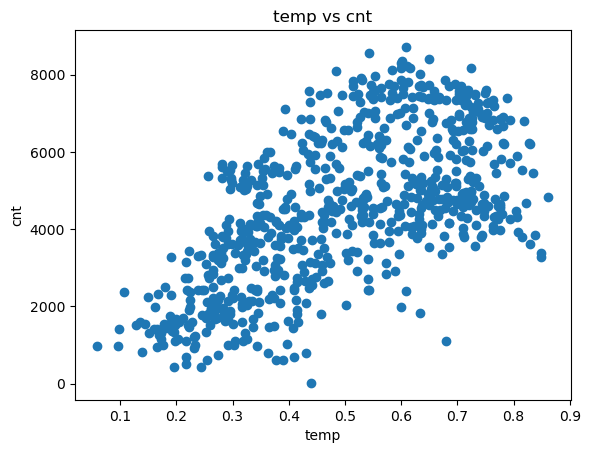

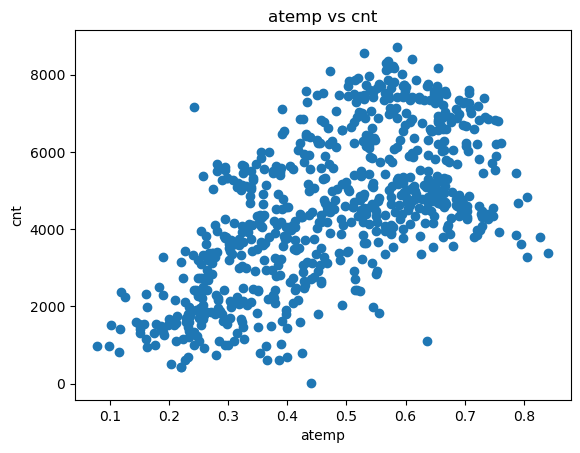

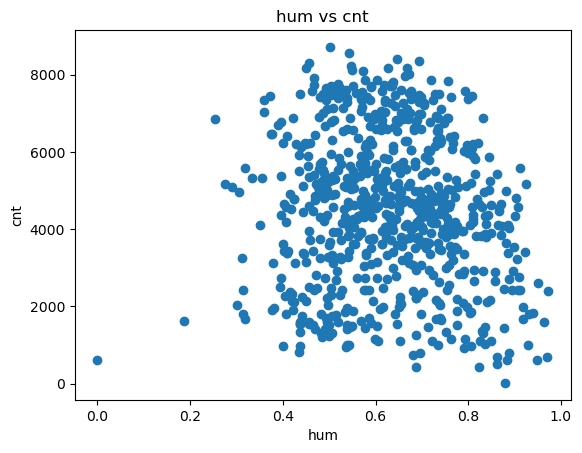

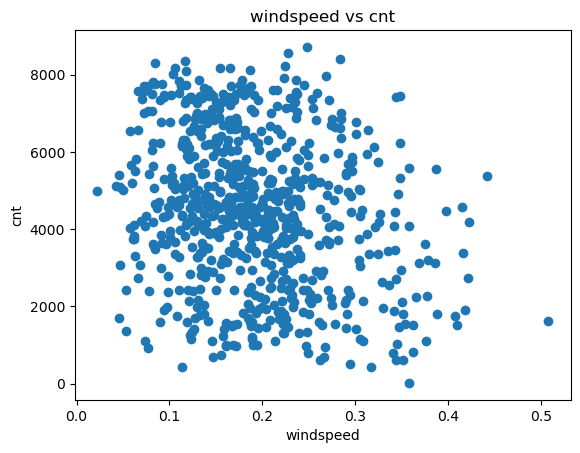

In [4]:
num_features = ['temp','atemp','hum','windspeed']

for i in num_features:
    plt.scatter(df[i],df['cnt'])
    plt.title(f'{i} vs cnt')
    plt.xlabel(i)
    plt.ylabel('cnt')
    plt.show()

Estas gráficas nos pueden ayudar a entender alguna relación entre las variables, en este caso tanto la variable **temp** y **atemp** parecen tener una relación postiva, a mayor incremento en $x$, mayor incremento en $y$, es decir, se rentan más bicicletas. En cuanto a las variables de hum y windspeed no se aprecia una relación tan clara, solo que la humedad suele ser alta y la velocidad del viento tiende a ser baja.

## Análisis bivariado

In [5]:
df_numerical = df[['temp','atemp','hum','windspeed','cnt']]
df_numerical = df_numerical.copy()

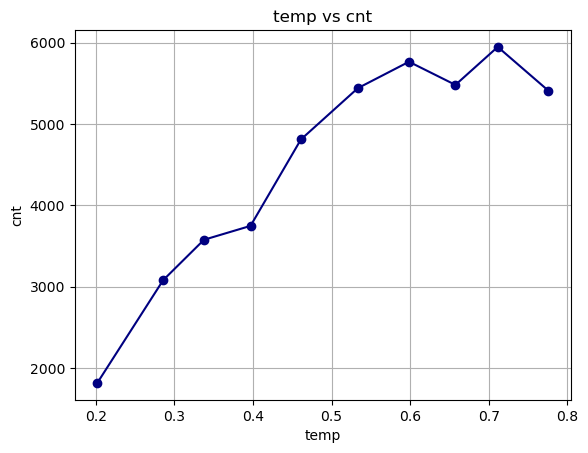

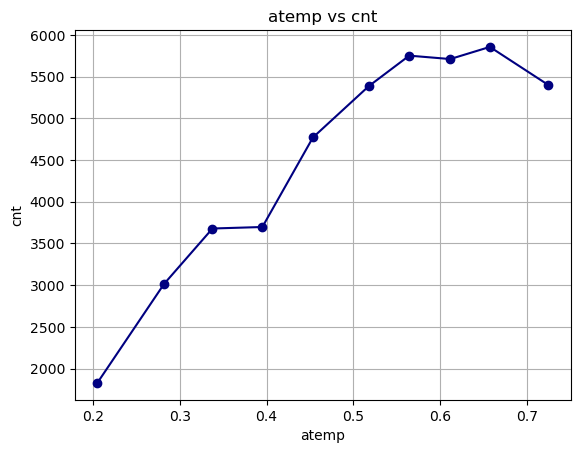

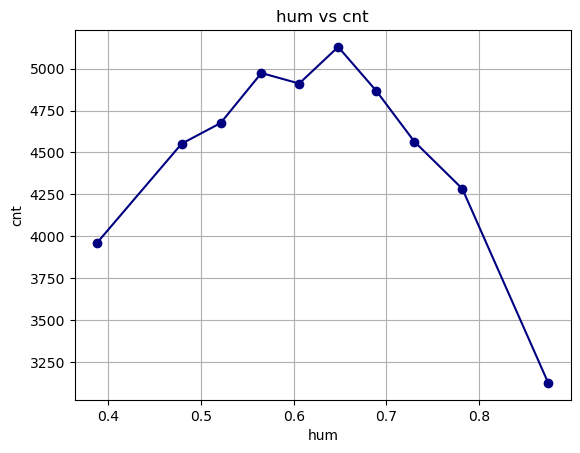

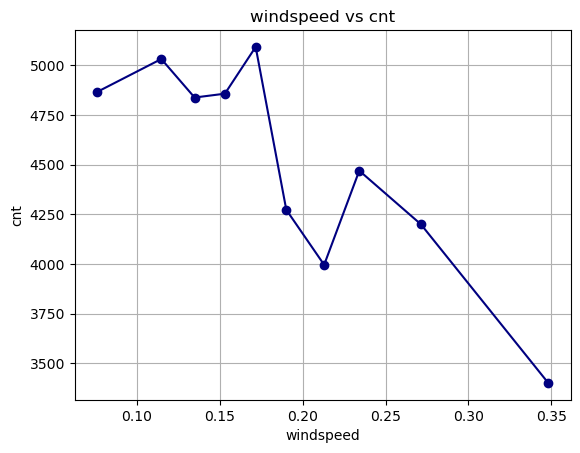

In [6]:
for feature in num_features:
    df_numerical[f'{feature}_bins'] = pd.qcut(df_numerical[feature], q=10, labels=False) + 1
    grouped = df_numerical.groupby(f'{feature}_bins').mean()
    plt.plot(grouped[feature], grouped['cnt'], marker='o', c='navy')
    plt.title(f'{feature} vs cnt')
    plt.xlabel(feature)
    plt.ylabel('cnt')
    plt.grid()
    plt.show()

Viendo la forma de las gráficas no se aprecia que haya una relación lineal entre las variables por si solas y el número de bicicletas, por otro lado debido al rango de las gráficas tanto **temp** como **atemp** podrían ser mejores variables predictoras, además hum tiene forma de parábola, por lo que podría tener una relación cuadrática con nuestra variable a predecir. Entonces haremos una regresión lineal múltiple para ver si jntando las variables se puede llegar a un buen modelo, y posteirormente se agregarán las variables dummies creadas para ver si hay mejora en el modelo.

In [7]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q = bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    plt.plot(grouped.predicciones, grouped.y, marker='o', label = 'Modelo', color = 'blue')
    plt.plot(grouped.predicciones, grouped.predicciones, marker='o', label = 'Real', color = 'red')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.legend()
    plt.grid()

## Modelos

In [8]:
X = df.copy()
X = X.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.2, random_state=42)

### Regresión Lineal Múltiple

In [9]:
model_linear = linear_model.LinearRegression().fit(X_train, y_train)
predicciones_lineal = model_linear.predict(X_test)
r2_score(y_pred = predicciones_lineal, y_true = y_test)

0.5546923653188565

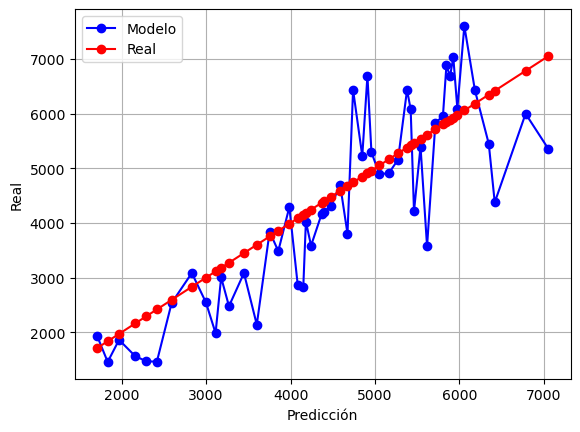

In [10]:
calibracion(predicciones_lineal, y_test, 50)

Este sería el modelo base, el cual cuenta con un r2 de 0.5546, y como apreciamos en la gráfica de calibración es bastante malo y falla en muchas predicciones, el objetico será ir construyendo mejores modelo que sean mejores a este, ya sea con otros modelos y modificando y agregando nuevas variables.

### Regresión Lineal Múltiple Estandarizada

In [11]:
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model_linear = linear_model.Ridge().fit(X_train, y_train)
predicciones_lineal_est = model_linear.predict(X_test)
r2_score(y_pred = predicciones_lineal_est, y_true = y_test)

0.5555629658192583

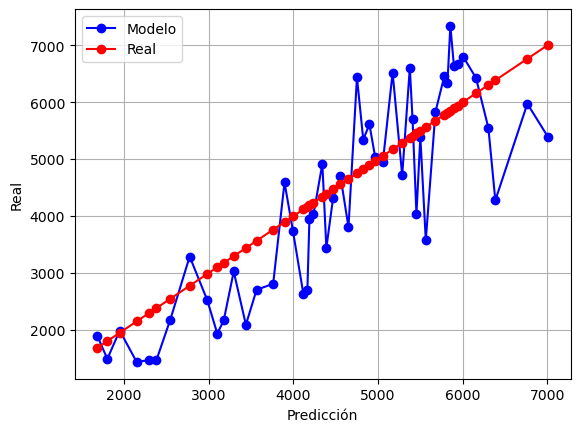

In [12]:
calibracion(predicciones_lineal_est, y_test, 50)

### Modelos polinomiales

In [13]:
degree = 2

# Aplicar StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Ajustar el modelo de regresión Lasso o ridge 
model = linear_model.Lasso().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly_2 = model.predict(X_test)
r2_score(y_pred=predicciones_poly_2, y_true=y_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.816e+06, tolerance: 2.141e+05
  model = cd_fast.enet_coordinate_descent(


0.5653434988020118

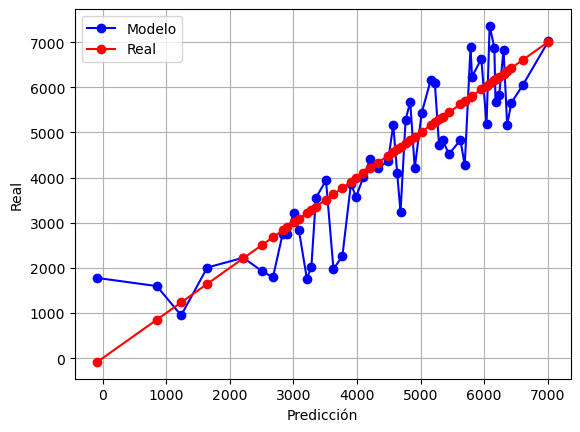

In [14]:
calibracion(predicciones_poly_2, y_test, 50)

Hubo una mejora en el r2 del modelo, pues ahora es de 0.5653, sin embargo, con la gráfica de calibración vemos que se cometiendo bastantes errores al momento de predecir.

In [15]:
degree = 3

# Aplicar StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Ajustar el modelo de regresión Lasso o ridge 
model = linear_model.Lasso().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly_3 = model.predict(X_test)
r2_score(y_pred=predicciones_poly_3, y_true=y_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.227e+08, tolerance: 2.141e+05
  model = cd_fast.enet_coordinate_descent(


0.2939333393055873

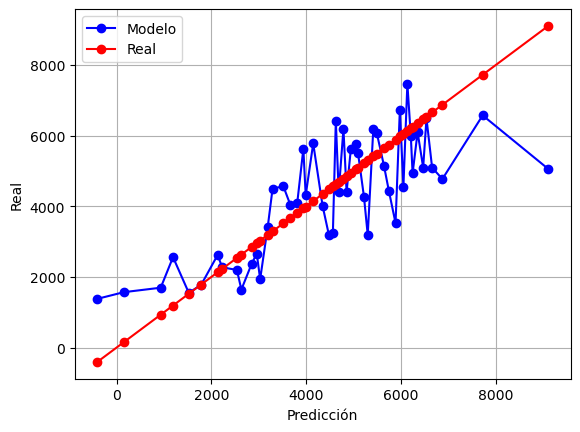

In [16]:
calibracion(predicciones_poly_3, y_test, 50)

A pesar de aumentar el el grado del polinomio, el resultado empeoró bastante. Por lo que continuamos con feature engeneering, en busca de mejorar el modelo.

## Feature Engeneering

Analizamos nuestra Dataframe para ver que se puede lograr con las variables que tenemos, aquí se busca agregar nuevas variables que hagan sentido o realizar transformaciones a las ya esxistente, para ello nos apoyaremos del análisis bivariado de las variables numéricas.

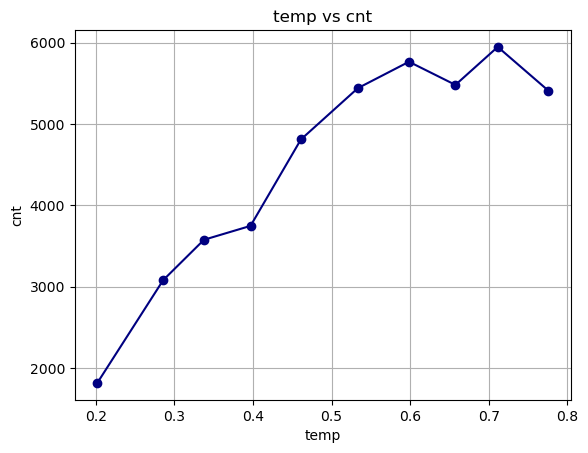

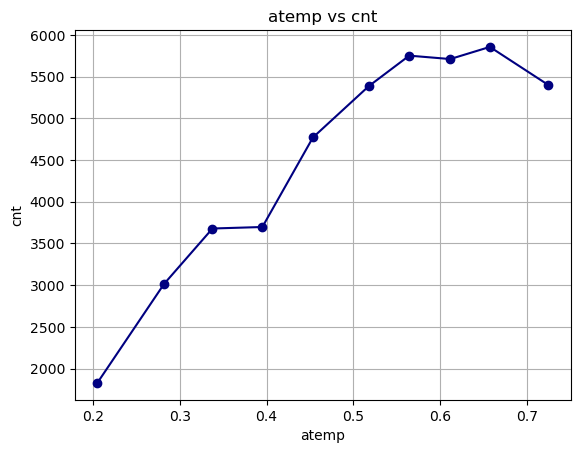

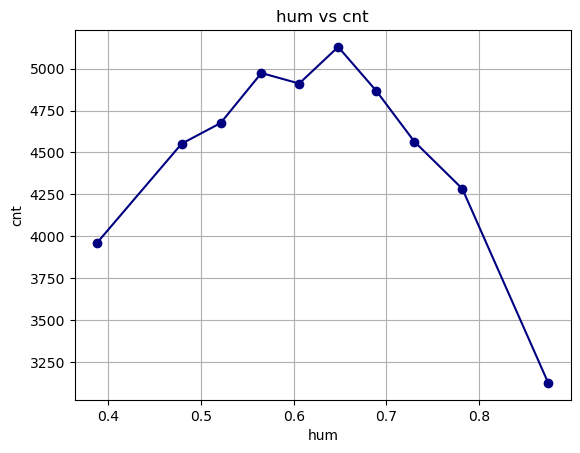

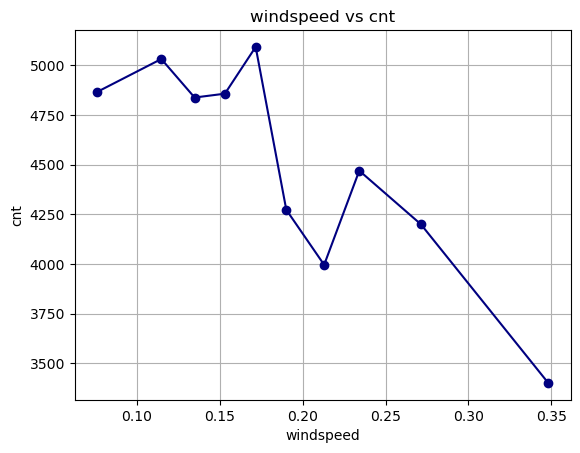

In [17]:
for feature in num_features:
    df_numerical[f'{feature}_bins'] = pd.qcut(df_numerical[feature], q=10, labels=False) + 1
    grouped = df_numerical.groupby(f'{feature}_bins').mean()
    plt.plot(grouped[feature], grouped['cnt'], marker='o', c='navy')
    plt.title(f'{feature} vs cnt')
    plt.xlabel(feature)
    plt.ylabel('cnt')
    plt.grid()
    plt.show()

In [18]:
# Per unit
df['hum_per_temp'] = df['hum'] / df['temp']

# Humedad tiene forma de parábola en relación a cnt
df['hum2'] = df['hum']**2

# Tanto temp como atemp tienen forma de raíz en relación a cnt, sin ser tan pronunciada
df['sqrt_temp'] = df['temp'] ** 0.9
df['sqrt_atemp'] = df['atemp'] ** 0.9

df['log_windspeed'] = np.log(df['windspeed'])

In [19]:
numerical_features = ['temp','atemp','hum','windspeed','hum_per_temp','hum2','sqrt_temp','sqrt_atemp','log_windspeed']

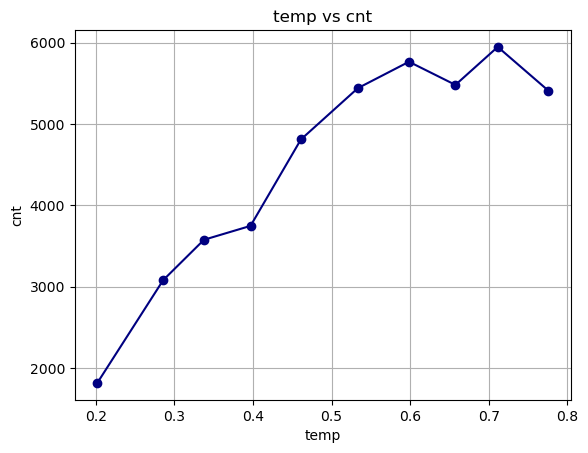

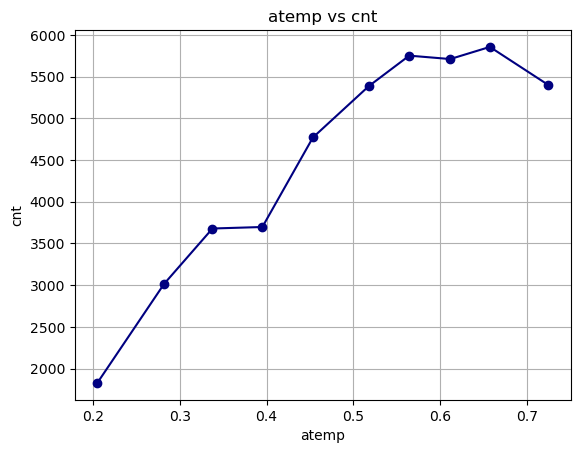

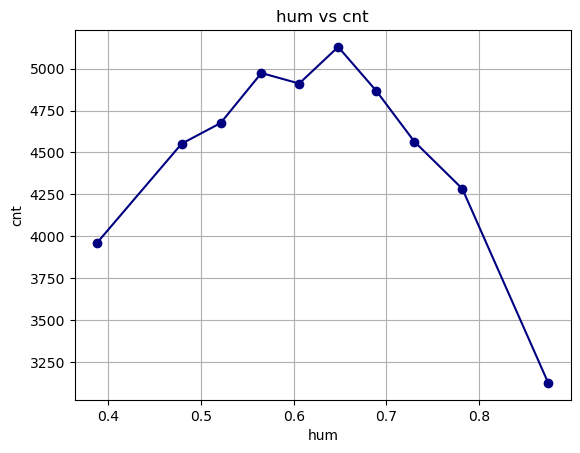

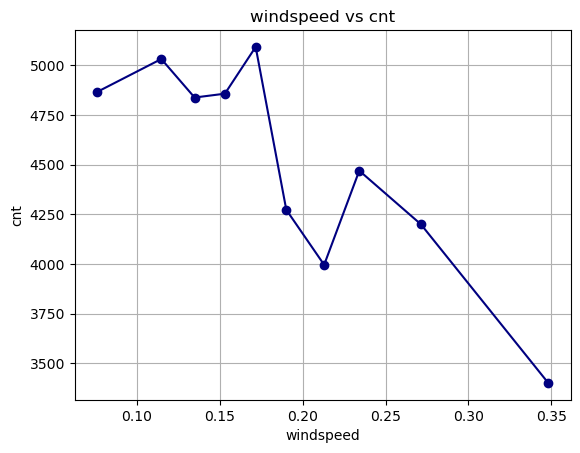

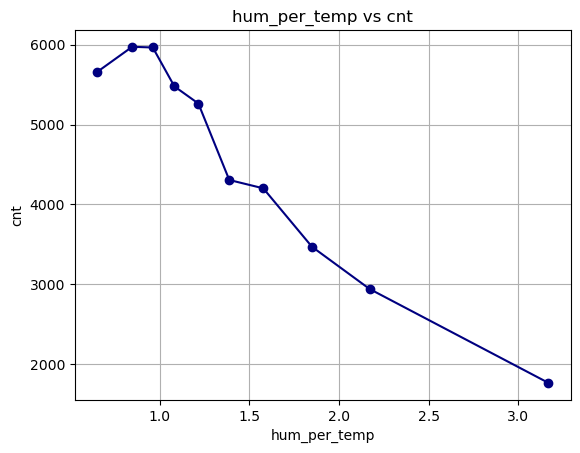

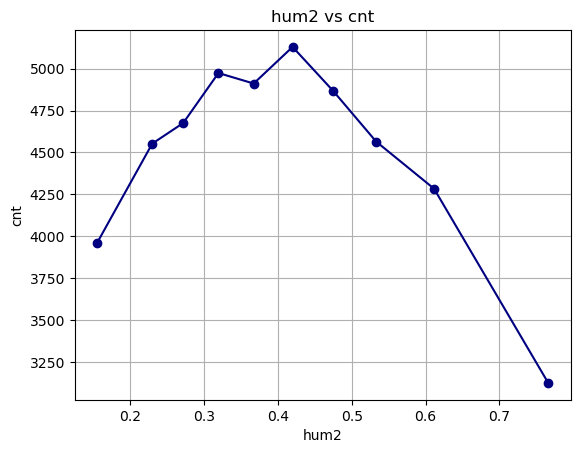

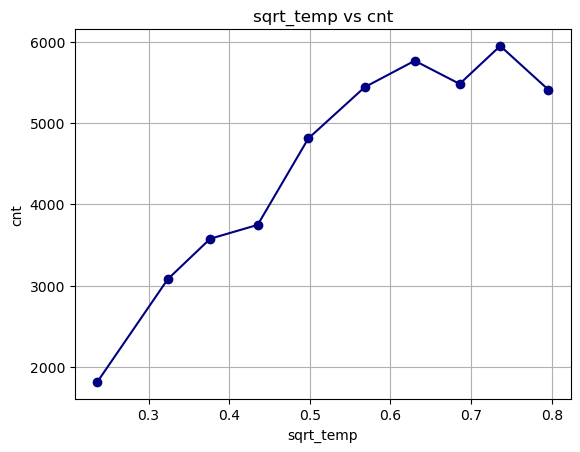

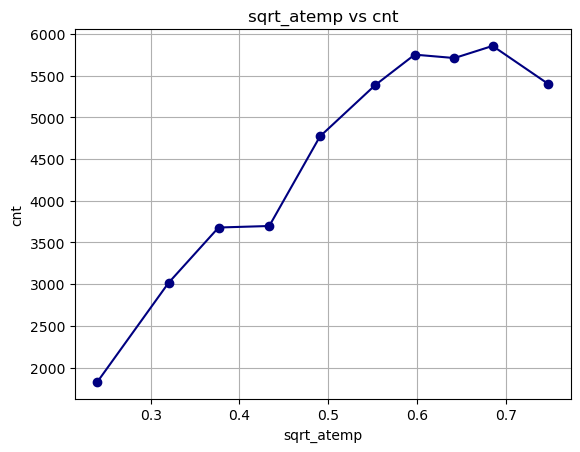

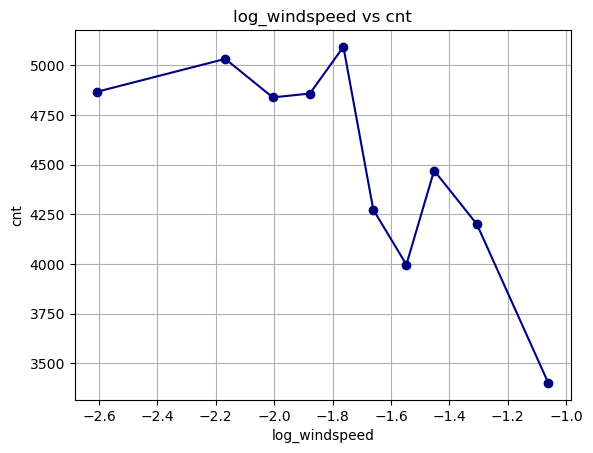

In [20]:
for feature in numerical_features:
    df[f'{feature}_bins'] = pd.qcut(df[feature], q=10, labels=False) + 1
    grouped = df.groupby(f'{feature}_bins').mean()
    plt.plot(grouped[feature], grouped['cnt'], marker='o', c='navy')
    plt.title(f'{feature} vs cnt')
    plt.xlabel(feature)
    plt.ylabel('cnt')
    plt.grid()
    plt.show()

### Probar Modelos

In [21]:
X = df.copy()
X = X.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.2, random_state=42)

model = linear_model.LinearRegression().fit(X_train, y_train)

predicciones_lineal2 = model.predict(X_test)
r2_score(y_pred=predicciones_lineal2, y_true=y_test)

0.6038815149835859

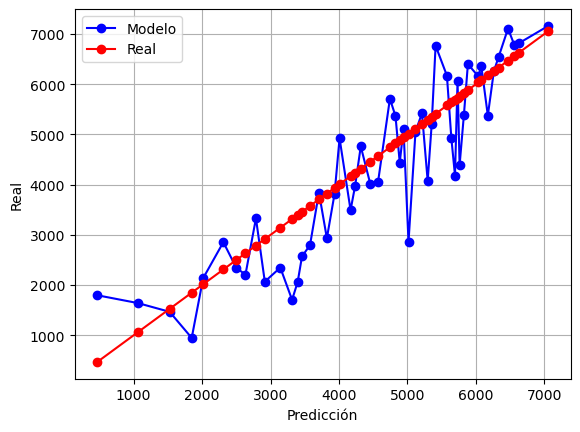

In [22]:
calibracion(predicciones_lineal2, y_test, 50)

Si bien el modelo mejora a un r2 de 0.6039, en la gráfica de calibración apreciamos que la predicción para los count de la mitad baja, el modelo tiene un error bastante grande.

In [23]:
degree = 2

# Aplicar StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

# Ajustar el modelo de regresión Lasso o ridge 
model = linear_model.Lasso().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly_2_fe = model.predict(X_test)
r2_score(y_pred=predicciones_poly_2_fe, y_true=y_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.352e+07, tolerance: 1.859e+05
  model = cd_fast.enet_coordinate_descent(


0.4107726412966306

In [24]:
degree = 3

# Aplicar StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

# Ajustar el modelo de regresión Lasso o ridge 
model = linear_model.Lasso().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly_3_fe = model.predict(X_test)
r2_score(y_pred=predicciones_poly_3_fe, y_true=y_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.892e+07, tolerance: 1.859e+05
  model = cd_fast.enet_coordinate_descent(


-1.456701248499014

Tanto con polinomio de grado 2 y 3 el r2 del modelo disminuye, por lo que no están sirviendo los modelos polinomiales. Entonces probamos la estrategia de convertir las variables numéricas a categóricas a través de los bins.

In [25]:
# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.2, random_state=42)
# Crea funcion bins para las variables numericas 
def create_bins(X, numeric_vars, bins):
    for var in numeric_vars:
        X[f'{var}_bin'] = pd.qcut(X[var], q = bins, labels=False, duplicates='drop') + 1
    return X

# Aplica la foruma de bins a x_trian y x_test
X_train = create_bins(X_train, numerical_features, 20)
X_test = create_bins(X_test, numerical_features, 20)
# Bin features
bins_features = [i for i in X_train.keys() if 'bin' in i]
cat_features = [i for i in X_train.keys() if 'bin' not in i]

# Final features 
final_features = bins_features + cat_features

# Apply get dummies to both pd.get_dummies(X_train[final_features], columns=bin_features, drop_first=True)
X_train = pd.get_dummies(X_train[final_features], columns=bins_features, drop_first=True)
X_test = pd.get_dummies(X_test[final_features], columns=bins_features, drop_first=True)

In [26]:
model = linear_model.Lasso()
model.fit(X_train, y_train)

predicciones_final = model.predict(X_test)
r2_score(y_pred=predicciones_final, y_true=y_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.250e+06, tolerance: 2.141e+05
  model = cd_fast.enet_coordinate_descent(


0.5467095234849089

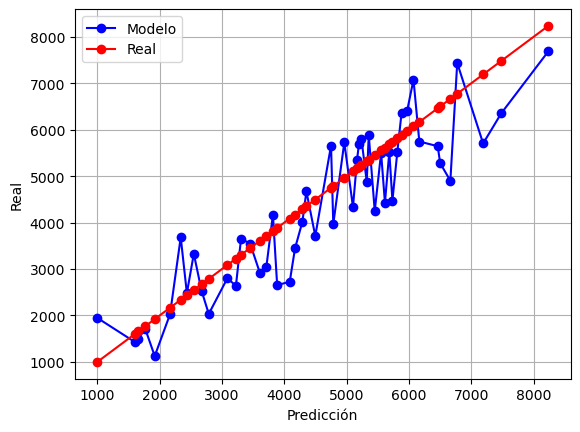

In [27]:
calibracion(predicciones_final, y_test, 50)

Utilizar la estrategia de los bins nos dio un r2 relativamente bueno, no fue el más alto, además de que en la gráfica de calibración vemos su mal ajuste.

## Modelo Final

In [28]:
X = df.copy()
X = X.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.2, random_state=42)

model = linear_model.LinearRegression().fit(X_train, y_train)

predicciones_lineal2 = model.predict(X_test)

In [29]:
print(f'R^2 del modelo: {r2_score(y_pred=predicciones_lineal2, y_true=y_test):.4f}')
print(f'MSE del modelo: {mean_squared_error(y_pred=predicciones_lineal2, y_true=y_test):.4f}')
print()

print(f'Intercepto: {model.intercept_}')
print('Coeficientes:')
coeficientes = pd.DataFrame({
    'variable': X.columns, 
    'coeficiente': model.coef_})
coeficientes

R^2 del modelo: 0.6039
MSE del modelo: 1588388.4972

Intercepto: -4062.388938664073
Coeficientes:


,variable,coeficiente
0,holiday,-380.692030
1,workingday,208.432728
2,temp,-406537.363227
3,atemp,224841.166615
4,hum,8819.587414
5,windspeed,-6093.540626
6,season_1,-408.792618
7,season_2,-121.185151
8,season_3,-59.172605
9,season_4,589.150374


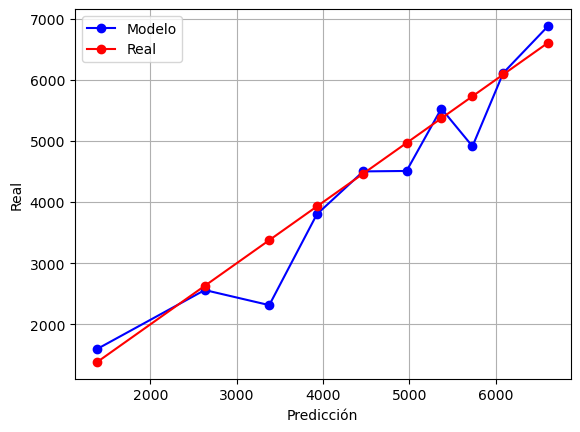

In [30]:
calibracion(predicciones_lineal2, y_test, 10)

Por último el mejor modelo fue el de regresión lineal múltiple después de realizar feature engineering a nuestros datos, obteniendo un r2 de 0.6039, lo cual significa que el modelo puede explicar el 60% de la variación de los datos, en la gráfica de calibración se aprecia el ajuste, si bien tiene errores fue el mejor modelo que se obtuvo y es bastante mejor que utilizar el promedio de los datos, por lo que tiene un buen poder predictivo.

## A/B Testing

In [31]:
df = pd.read_csv('day.csv')

In [32]:
df_ab = df[['workingday','holiday','cnt']]
df_ab

,workingday,holiday,cnt
0,0,0,985
1,0,0,801
2,1,0,1349
3,1,0,1562
4,1,0,1600
...,...,...,...
726,1,0,2114
727,1,0,3095
728,0,0,1341
729,0,0,1796


In [33]:
df_test = df_ab[df_ab['holiday'] == 1]
df_control = df_ab[df_ab['workingday'] == 1]

### A mano

In [34]:
mu_test = df_test['cnt'].mean()
mu_control = df_control['cnt'].mean()

se_test = df_test['cnt'].sem()
se_control = df_control['cnt'].sem()

mu_diff = mu_control - mu_test
se_diff = np.sqrt(se_test**2 + se_control**2)

z = mu_diff / se_diff
p_value = stats.norm.cdf(z)

In [35]:
print(f'Variable test entre: {mu_test - 2*se_test} y {mu_test + 2*se_test}')
print(f'Variable control entre: {mu_control - 2*se_control} y {mu_control + 2*se_control}')
print(f'Intervalo de confianza del efecto causal de ser test entre {mu_diff - 2*se_diff} y {mu_diff + 2*se_diff}')
print(f'Z score: {z}')
print(f'P value: {p_value}')

Variable test entre: 2817.022512984841 y 4652.97748701516
Variable control entre: 4416.809402672246 y 4752.830597327754
Intervalo de confianza del efecto causal de ser test entre -83.40571089801006 y 1783.0457108980095
Z score: 1.8212528653593316
P value: 0.9657157861186356


Con los resultados obtenidos podemos ver que el promedio de bicicletas rentadas en días festivos es de entre 2817 y 4652, y en días laborales va de entre 4416 y 4752, dando a entender que en promedio se rentan más bicicletas en días laborales, sin embargo, el A/B testing se realizó para ver si esta afirmación tiene evidencia estadística que la respalde.

El intervalo de confianza de la diferencia esta entre -83 y 1783, lo que significa que en días festivos se podrían llegar a rentar 83 biciletas más en promedio que en un día de trabajo, o que en un día de trabajo se podrían rentar hasta 1783 bicicletas más en promedio en compración a un día festivo. Que el cero se encuentre dentro del intervalo es interesnate para el análisis.

El Z-score es relativamente alto, de 1.82. El P-value tan alto de 0.96 nos dice que no se podría rechazar la hipotésis nula (no hay diferencia). Esto significa que un un 95% de confianza se podría decir que no hay evidencia estadística que sugiera que existe una diferencia entre las bicicletas rentadas en días festivos o de trabajo, dado que el cero se encuentra dentro del intervalo nos dice que hasta cierto punto la diferencia que exista es por coincidencia.

### Con función

In [36]:
result = smf.ols('cnt ~ holiday + workingday', data=df).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4389.6857,133.413,32.903,0.000,4127.766,4651.605
holiday,-654.6857,442.480,-1.480,0.139,-1523.375,214.004
workingday,195.1343,158.980,1.227,0.220,-116.979,507.248


Dado que el p-value de ambas variables es mayor a 0.05, nos dice que ninguna de las dos variables es significativa para el modelo de predicción del número de bicicletas.